In [1]:
import sys
sys.path.append('/home/clarkmaio/workspace/slurp/')

import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import torch

from slurp import GnAM, s, l, cs, f
from slurp.src.module.spline import sModule
from slurp.src.module.cyclic_spline import csModule

# Demo splines

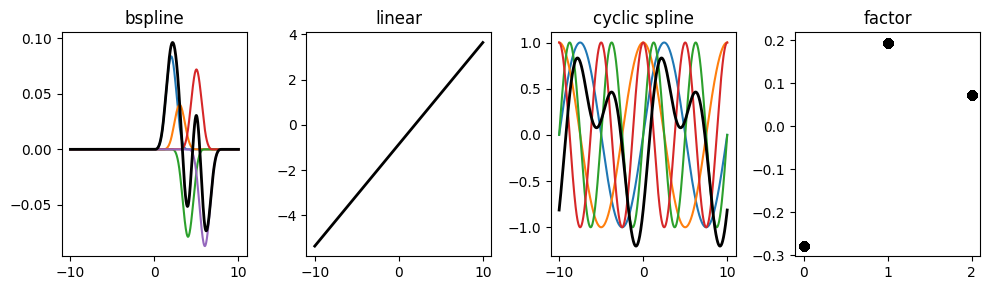

In [4]:
# Example usage

x = pl.DataFrame({
    'x': np.linspace(-10, 10, 1000),
    'class': np.random.randint(0, 3, size=1000)
    })



knots = [0, 1, 2, 3, 4, 5, 6, 7, 8]
bspline = s(term='x', knots=knots, degree=3)
lspline = l(term='x')
cspline = cs(term='x', period=10, order=2, bias=False)
fspline = f(term='class', num_classes=3)

fig, ax = plt.subplots(figsize=(10, 3), ncols=4, nrows=1, sharex=False)

ax[0].plot(x['x'], bspline.predict_basis(x, scaled=True))
ax[0].plot(x['x'], bspline.predict(x), color='k', linewidth=2.)
ax[0].set_title('bspline')

ax[1].plot(x['x'], lspline.predict(x), color='k', linewidth=2.)
ax[1].set_title('linear')

ax[2].plot(x['x'], cspline.predict_basis(x, scaled=False))
ax[2].plot(x['x'], cspline.predict(x), color='k', linewidth=2.)
ax[2].set_title('cyclic spline')

ax[3].scatter(x['class'], fspline.predict(x), color='k')
ax[3].set_title('factor')

plt.tight_layout()
plt.show()

In [ ]:
bspline.grad(x)

# Demo regression

Text(0.5, 1.0, 'Synthetic Data')

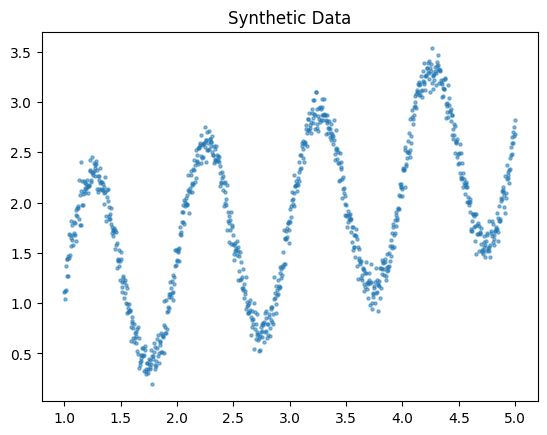

In [20]:
N = 1000
start_range = 1
end_range = 5
noise = 0.1
xx = np.linspace(start_range, end_range, N)
noise = noise * np.random.randn(N)
yy =  np.exp(xx/5) + noise  + np.sin(2 * np.pi * xx)

plt.scatter(xx, yy, s=5, alpha=0.5)
plt.title('Synthetic Data')

In [21]:
X, y = pl.DataFrame({'x': xx, 'random': np.random.randn(len(xx))}), pl.Series(values=yy, name='y')
X = X.select(pl.all().cast(pl.Float32))
y = y.cast(pl.Float32)

In [22]:
GAMMA = 100.
WEIGHT_DECAY = 0.1
LR = 0.05
EPOCHS = 2000

gm_add = GnAM(
    design =  (
        (cs(term='x', period=1, order=5) + l(term='x', bias=True)) 
        * s(term='x', knots=[-1, 0, 1,2,3,4,5, 6, 7, 8], degree=1, tag='mul spline') 
    )
)

gm_add.fit(X, y, epochs=EPOCHS, lr = LR, weight_decay=WEIGHT_DECAY, gamma=GAMMA)
ypred_add = gm_add.predict(X)


Epoch 1901/2000 - Loss: 0.0181: 100%|██████████| 2000/2000 [00:08<00:00, 230.45it/s]


Text(0.5, 1.0, 'GnAM Fit')

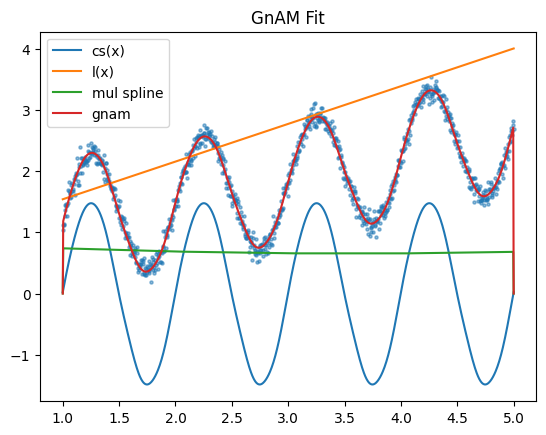

In [23]:
plt.scatter(xx, yy, s=5, alpha=0.5)
#plt.plot(xx, ypred_add, color='k', linewidth=3., label='Additive')
plt.plot(xx, gm_add.predict_components(X), label=gm_add.predict_components(X).columns)
plt.legend()
plt.title('GnAM Fit')

In [24]:
from IPython.display import display, Math, Latex
display(Math(gm_add.to_latex(compact=False)))

<IPython.core.display.Math object>